In [1436]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from stochastic_gradient_descent import stochastic_gradient_descent
from knn import knn
from kernel_svm import kernel_svm
from naive_bayes import naive_bayes
from random_forest import random_forest
from voting_classifier import voting_classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

In [1483]:
league_id = 72 # Choose the league id
min_threshold = 1.75
max_threshold = 10

# default_stake = 50
bankroll = 2000
stake = 0.025

In [1484]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')
    
def get_season_year(season_id):
    if len(str(season_id)) == 4:
        return int(season_id)
    return int(str(season_id)[1:])

def check_bet_worth(prediction, odds_home, odds_away, odds_draw, pred_odds_home, pred_odds_away, pred_odds_draw):
    return ((prediction == 'H' and (pred_odds_home < odds_home) and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (pred_odds_away < odds_away) and (odds_away > min_threshold and odds_away < max_threshold)) or
            (prediction == 'D' and (pred_odds_draw < odds_draw) and (odds_draw > min_threshold and odds_draw < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw):
    game_money = 0
    
    if check_bet_worth(prediction, game['HOME_ODDS'], game['AWAY_ODDS'], game['DRAW_ODDS'], pred_odds_home, pred_odds_away, pred_odds_draw):
        if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
            game_money = (bet_value*game['HOME_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
            game_money = (bet_value*game['AWAY_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
            game_money = (bet_value*game['DRAW_ODDS'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw):
    
    prediction = 'D'
    if game['HOME_ODDS'] > game['AWAY_ODDS']:
        prediction = 'H'
    elif game['AWAY_ODDS'] > game['HOME_ODDS']:
        prediction = 'A'
    
    return check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

In [1485]:
print('\nGetting data for the model...')

season_file = '2014-2022'

first_season_train = 2014
last_season_train = 2021

season = "{}-{}".format(first_season_train, last_season_train)

default_path = f'./leagues/{league_id}'
whole_dataset = (pd.read_csv(f'{default_path}/data/{season_file}.csv')).dropna()
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date

dataset_train = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season_train) & (whole_dataset['SEASON'] <= last_season_train)].reset_index(drop=True)

first_season_test = 2022
last_season_test = 2022

dataset = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season_test) & (whole_dataset['SEASON'] <= last_season_test)].reset_index(drop=True)

results = []

X_train = dataset_train.iloc[:, 9:-1].values
X = dataset.iloc[:, 9:-1].values
y = dataset.iloc[:, -1].values


Getting data for the model...


In [1486]:
dataset_train.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_AWAY_DRAW_PCT,AWAY_AWAY_LOSS_PCT,AWAY_SCORED_LAST_5,AWAY_CONCEDED_LAST_5,AWAY_AWAY_SCORED_LAST_5,AWAY_AWAY_CONCEDED_LAST_5,AWAY_WIN_PCT_5,AWAY_DRAW_PCT_5,AWAY_LOSS_PCT_5,OUTCOME
0,0,468890,2014-07-15,2014,Ponte Preta,Portuguesa,2.03,3.49,3.33,53.333333,...,40.000000,60.0,1.4,1.6,1.000000,1.5,40.0,20.0,40.0,D
1,1,468900,2014-07-18,2014,Portuguesa,Parana,1.89,4.02,3.37,30.303030,...,33.333333,50.0,1.0,1.4,1.000000,1.5,20.0,20.0,60.0,D
2,2,468901,2014-07-18,2014,ABC,Joinville,2.73,2.56,3.15,51.515152,...,20.000000,40.0,1.0,0.6,1.500000,1.5,60.0,20.0,20.0,H
3,3,468902,2014-07-18,2014,America MG,Oeste,1.37,8.08,4.45,60.606061,...,20.000000,60.0,0.8,1.2,0.500000,1.5,20.0,60.0,20.0,H
4,4,468903,2014-07-18,2014,Avai,Ponte Preta,2.38,2.94,3.20,51.515152,...,40.000000,40.0,1.2,1.2,1.666667,2.0,40.0,20.0,40.0,H


In [1487]:
dataset.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_AWAY_DRAW_PCT,AWAY_AWAY_LOSS_PCT,AWAY_SCORED_LAST_5,AWAY_CONCEDED_LAST_5,AWAY_AWAY_SCORED_LAST_5,AWAY_AWAY_CONCEDED_LAST_5,AWAY_WIN_PCT_5,AWAY_DRAW_PCT_5,AWAY_LOSS_PCT_5,OUTCOME
0,1955,838724,2022-06-06,2022,Guarani,Operario,1.92,4.47,3.10,30.000000,...,60.0,40.0,1.4,1.2,0.500000,1.000000,40.0,20.0,40.0,A
1,1956,838733,2022-06-07,2022,Vila Nova FC,Brusque,2.06,3.90,3.08,33.333333,...,0.0,100.0,0.6,1.2,0.500000,2.000000,20.0,20.0,60.0,A
2,1957,838727,2022-06-07,2022,Criciuma,Sampaio Correa,1.64,6.03,3.48,33.333333,...,20.0,80.0,1.0,1.0,0.333333,1.333333,40.0,20.0,40.0,H
3,1958,838728,2022-06-07,2022,Ituano,Ponte Preta,2.08,4.17,2.93,33.333333,...,20.0,80.0,0.4,1.0,0.666667,1.333333,0.0,40.0,60.0,A
4,1959,838731,2022-06-08,2022,Bahia,Sport Recife,1.92,4.58,3.05,63.333333,...,60.0,20.0,1.0,0.4,0.500000,0.000000,60.0,20.0,20.0,H


In [1488]:
directory = f'{default_path}/models/{season}'
if not os.path.exists(directory):
    os.makedirs(directory)

In [1489]:
print('\nExecuting the logistic Regression model...')
Pkl_Filename = "{}/LogisticRegressionModel.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        logisticRegression = pickle.load(file)
except:
    logisticRegression = logistic_regression(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(logisticRegression, file)
results.append(dict(model='Logistic Regression',cm=logisticRegression[0], acc=logisticRegression[1], classifier=logisticRegression[2]))



Executing the logistic Regression model...


In [1490]:
print('\nExecuting the Stochastic Gradient Descent model...')
Pkl_Filename = "{}/StochasticGradientDescent.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        sgd = pickle.load(file)
except:
    sgd = stochastic_gradient_descent(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(sgd, file)
results.append(dict(model='Stochastic Gradient Descent',cm=sgd[0], acc=sgd[1], classifier=sgd[2]))



Executing the Stochastic Gradient Descent model...


In [1491]:
print('\nExecuting the KNN model...')
Pkl_Filename = "{}/KNN.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        knn_model = pickle.load(file)
except:
    knn_model = knn(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(knn_model, file)
results.append(dict(model='KNN',cm=knn_model[0], acc=knn_model[1], classifier=knn_model[2]))



Executing the KNN model...


In [1492]:
print('Executing the Kernel SVM model...')
Pkl_Filename = "{}/KernelSVM.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        svm = pickle.load(file)
except:
    svm = kernel_svm(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(svm, file)
results.append(dict(model='Kernel SVM',cm=svm[0], acc=svm[1], classifier=svm[2]))

Executing the Kernel SVM model...


In [1493]:
print('Executing the Naive Bayes model...')
Pkl_Filename = "{}/NaiveBayes.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        nb = pickle.load(file)
except:
    nb = naive_bayes(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(nb, file)
results.append(dict(model='Naive Bayes',cm=nb[0], acc=nb[1], classifier=nb[2]))

Executing the Naive Bayes model...


In [1494]:
print('Executing the Random Forest model...')
Pkl_Filename = "{}/RandomForest.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        rf = pickle.load(file)
except:
    rf = random_forest(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(rf, file)
results.append(dict(model='Random Forest',cm=rf[0], acc=rf[1], classifier=rf[2]))

Executing the Random Forest model...


In [1495]:
print('Executing the Voting Classifier model...')
Pkl_Filename = "{}/VotingClassifier.pkl".format(directory)

estimators = [('lr', logisticRegression[2]), ('svm', svm[2]), ('nb', nb[2]), ('sgd', sgd[2])]
weights = [1,1,1,1]

try:
    with open(Pkl_Filename, 'rb') as file:  
        vc = pickle.load(file)
except:
    vc = voting_classifier(dataset, estimators, weights)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(vc, file)
results.append(dict(model='Voting Classifier',cm=vc[0], acc=vc[1], classifier=vc[2]))

Executing the Voting Classifier model...



Getting the feature correlation matrix...


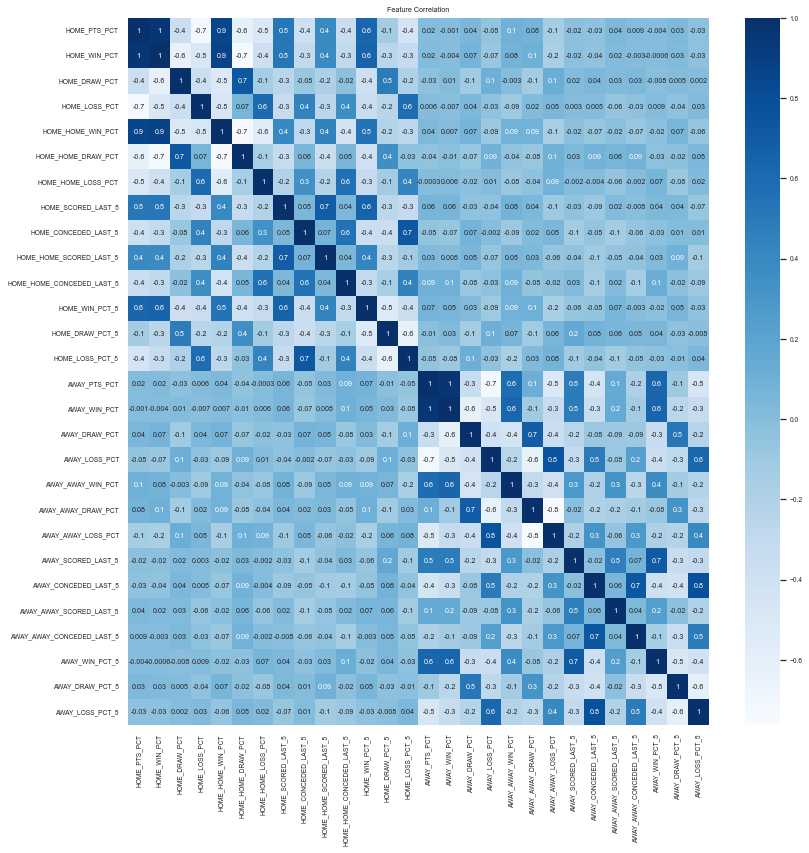

In [1496]:
print('\nGetting the feature correlation matrix...')

import seaborn as sns

try:
    dependent_variables = dataset.iloc[:,9:]
    corrmat = dependent_variables.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(13,13))
    title = 'Feature Correlation'
    plt.title(title)
    #plot heat map
    sns.set(font_scale=0.6)
    g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()
except:
    print('No correlation matrix for the selected model.')

In [1497]:
directory = f'{default_path}/scalers'
if not os.path.exists(directory):
    os.makedirs(directory)

from sklearn.preprocessing import StandardScaler
sc_train = StandardScaler()
sc_train.fit(X_train)

Pkl_ScalerName = "{}/{}.pkl".format(directory, season)
with open(Pkl_ScalerName, 'wb') as file:  
    pickle.dump(sc_train, file)

X_transformed = sc_train.transform(X)

In [1498]:
print('\nGetting classification model with the best predictions...')

modelCont = 0
probs = dict()
total_invested = dict()
while True:
    try:
        total_invested[results[modelCont]['model']] = 0
        results[modelCont]['pred'] = results[modelCont]['classifier'].predict(X_transformed)
        probs[results[modelCont]['model']] = results[modelCont]['classifier'].predict_proba(X_transformed)
        results[modelCont]['acc_test'] = accuracy_score(y, results[modelCont]['pred'])
        if results[modelCont]['model'] == 'Voting Classifier':
            y_pred = results[modelCont]['pred']
            y_prob = results[modelCont]['classifier'].predict_proba(X_transformed)
        modelCont += 1
    except IndexError:
        break

results.sort(key=lambda x: x['acc_test'], reverse=True)

odds_baseline = dataset[((dataset['HOME_ODDS'] <= dataset['AWAY_ODDS']) & (dataset['HOME_ODDS'] <= dataset['DRAW_ODDS']) & (dataset['OUTCOME'] == 'H')) | 
                   ((dataset['AWAY_ODDS'] <= dataset['HOME_ODDS']) & (dataset['AWAY_ODDS'] <= dataset['DRAW_ODDS']) & (dataset['OUTCOME'] == 'A')) |
                       ((dataset['DRAW_ODDS'] <= dataset['HOME_ODDS']) & (dataset['DRAW_ODDS'] <= dataset['AWAY_ODDS']) & (dataset['OUTCOME'] == 'D'))]

print('\nResults Classification:')
results.sort(key=lambda x: x['acc_test'], reverse=True)
[print('{}:\t{:.4f}'.format(x['model'], x['acc_test'])) for x in results]
print('Baseline Odds:\t{:.4f}'.format(100*len(odds_baseline.index)/len(dataset.index)))


Getting classification model with the best predictions...

Results Classification:
Voting Classifier:	0.5412
Logistic Regression:	0.4948
Kernel SVM:	0.4897
Random Forest:	0.4536
Stochastic Gradient Descent:	0.4433
Naive Bayes:	0.3969
KNN:	0.3505
Baseline Odds:	44.3299


In [1499]:
for i in range(10):
    print(y_prob[i,:], y_pred[i])

[0.31014694 0.44347093 0.24638214] D
[0.44083045 0.41086497 0.14830459] A
[0.26207474 0.2719042  0.46602106] H
[0.49277832 0.15997767 0.34724402] A
[0.0772501  0.17555625 0.74719365] H
[0.13498474 0.23370374 0.63131152] H
[0.4913202  0.16687401 0.34180579] A
[0.33109109 0.21913112 0.44977779] H
[0.4458417  0.41473449 0.1394238 ] A
[0.29589924 0.22476886 0.4793319 ] H


In [1500]:
def get_pred_odds(probs):
    return 1/probs[0], 1/probs[1], 1/probs[2] # Away, Draw, Home

In [1501]:
print("\nGetting data from the regular models for visualization...")
money_by_date = []
bets_tracking_odds = [0]
money_by_team = dict()
bets = []
parlay_model = dict(zip([x['model'] for x in results], [[0, True, []] for x in results]))

# dataset_filtered = dataset.loc[dataset['GAME_DATE'] > dt.date(2022, 8, 25)]

money_by_date.append([dataset.iloc[0,2], dict(zip([x['model'] for x in results], [0 for x in results])),  dict(zip([x['model'] for x in results], [bankroll for x in results]))])

for index, game in dataset.iterrows():
    # Next date
    if game['GAME_DATE'] != money_by_date[-1][0]:    
        bets_tracking_odds.append(bets_tracking_odds[-1])
        
        # Tracking built parlay
        for model in money_by_date[-1][1]:
            if parlay_model[model][0] >= 1.5:
                bet_value = get_bet_value(money_by_date[-1][2][model])
                game_money_model = ((parlay_model[model][0] * bet_value) - bet_value) if parlay_model[model][1] else -bet_value
                total_invested[model] += bet_value
                money_by_date[-1][1][model] += game_money_model
                money_by_date[-1][2][model] += game_money_model
                if model == 'Voting Classifier' and parlay_model[model][0] > 0:
                    print('\nPARLAY LIST:')
                    print(f"ODDS: {parlay_model[model][0]} \nMATCHES: {parlay_model[model][2]}\n")
                    
        parlay_model = dict(zip([x['model'] for x in results], [[0, True, []] for x in results]))
        money_by_date.append([game['GAME_DATE'],  dict(zip([x['model'] for x in results], [0 for x in results])), dict(money_by_date[-1][2])])
    
    if game['HOME_TEAM'] not in money_by_team:
        money_by_team[game['HOME_TEAM']] = 0
    if game['AWAY_TEAM'] not in money_by_team:
        money_by_team[game['AWAY_TEAM']] = 0
    
    pred_odds_away, pred_odds_draw, pred_odds_home  = get_pred_odds(y_prob[index,:])
    bets_tracking_odds[-1] += check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)
    
    print(f"\nGAME DATE: {game['GAME_DATE']}")
    print(f"GAME OUTCOME: {game['OUTCOME']}")
    print(f"PREDICTED OUTCOME: {y_pred[index]}")
    print(f"GAME: {game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}")

    for model in money_by_date[-1][1]:
        game_money_model = 0
        bet_value = get_bet_value(money_by_date[-1][2][model])
        prediction = next(x['pred'][index] for x in results if x['model'] == model)
        
        if probs[model][index,0] == 1 or probs[model][index,0] == 0:
            continue
            
        pred_odds_away, pred_odds_draw, pred_odds_home = get_pred_odds(probs[model][index, :])
        game_money_model = check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)
        
        if game_money_model != 0:
            if model == 'Voting Classifier': # Main Model
                if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
                    bets.append(['HOME', game['HOME_ODDS'], pred_odds_home, 1])
                    money_by_team[game['HOME_TEAM']] += game_money_model
                elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
                    bets.append(['AWAY', game['AWAY_ODDS'], pred_odds_away, 1])
                    money_by_team[game['AWAY_TEAM']] += game_money_model
                elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
                    bets.append(['DRAW', game['DRAW_ODDS'], pred_odds_draw, 1])
                else:
                    if prediction == 'H':
                        bets.append(['HOME', game['HOME_ODDS'], pred_odds_home, 0])
                        money_by_team[game['HOME_TEAM']] += game_money_model
                    elif prediction == 'A':
                        bets.append(['AWAY', game['AWAY_ODDS'], pred_odds_away, 0])
                        money_by_team[game['AWAY_TEAM']] += game_money_model
                    else:
                        bets.append(['DRAW', game['DRAW_ODDS'], pred_odds_draw, 0])
                        
            total_invested[model] += bet_value
            
        elif parlay_model[model][1] and prediction == game['OUTCOME']:
            odds = game['HOME_ODDS'] if prediction == 'H' else game['AWAY_ODDS'] if prediction == 'A' else game['DRAW_ODDS']
            parlay_model[model][0] = odds * parlay_model[model][0] if parlay_model[model][0] > 0 else odds # Parlay odds
            parlay_model[model][2].append(f"{game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}") # Parlay match counter
        else:
            parlay_model[model][1] = False # Parlay failed
            
        money_by_date[-1][1][model] += game_money_model
        money_by_date[-1][2][model] += game_money_model




Getting data from the regular models for visualization...

GAME DATE: 2022-06-06
GAME OUTCOME: A
PREDICTED OUTCOME: D
GAME: Guarani (1.92) x (4.47) Operario

GAME DATE: 2022-06-07
GAME OUTCOME: A
PREDICTED OUTCOME: A
GAME: Vila Nova FC (2.06) x (3.9) Brusque

GAME DATE: 2022-06-07
GAME OUTCOME: H
PREDICTED OUTCOME: H
GAME: Criciuma (1.64) x (6.03) Sampaio Correa

GAME DATE: 2022-06-07
GAME OUTCOME: A
PREDICTED OUTCOME: A
GAME: Ituano (2.08) x (4.17) Ponte Preta

PARLAY LIST:
ODDS: 1.64 
MATCHES: ['Criciuma (1.64) x (6.03) Sampaio Correa']


GAME DATE: 2022-06-08
GAME OUTCOME: H
PREDICTED OUTCOME: H
GAME: Bahia (1.92) x (4.58) Sport Recife

GAME DATE: 2022-06-10
GAME OUTCOME: H
PREDICTED OUTCOME: H
GAME: Sampaio Correa (2.18) x (3.49) Nautico

GAME DATE: 2022-06-11
GAME OUTCOME: A
PREDICTED OUTCOME: A
GAME: Brusque (2.24) x (3.57) Ituano

GAME DATE: 2022-06-11
GAME OUTCOME: H
PREDICTED OUTCOME: H
GAME: CRB (2.49) x (3.32) Vila Nova FC

GAME DATE: 2022-06-11
GAME OUTCOME: A
PREDICTED OU

C:\Users\caiog\AppData\Local\Temp\ipykernel_28300\1250689490.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/probs[0], 1/probs[1], 1/probs[2] # Away, Draw, Home


In [1502]:
print('\nProfit and margin by model...')
for model in money_by_date[-1][1]:
    if total_invested[model] > 0:
        won = money_by_date[-1][2][model] - bankroll
        print('Model: {} \t// Invested: {} \t// Won: {:.2f} \t// Margin: {:.2f}%'.format(model, total_invested[model], won, 100*won/total_invested[model]))


Profit and margin by model...
Model: Voting Classifier 	// Invested: 28400.0 	// Won: 12671.66 	// Margin: 44.62%
Model: Logistic Regression 	// Invested: 8775.0 	// Won: 3370.45 	// Margin: 38.41%
Model: Kernel SVM 	// Invested: 9175.0 	// Won: 3209.37 	// Margin: 34.98%
Model: Random Forest 	// Invested: 8425.0 	// Won: 2170.09 	// Margin: 25.76%
Model: Stochastic Gradient Descent 	// Invested: 6975.0 	// Won: -52.34 	// Margin: -0.75%
Model: Naive Bayes 	// Invested: 8775.0 	// Won: 376.90 	// Margin: 4.30%
Model: KNN 	// Invested: 6525.0 	// Won: -847.31 	// Margin: -12.99%


In [1503]:
print('\nPlotting charts...')

models_tracking =  [np.array([x[2][model] for x in money_by_date], dtype=np.float32) for model in money_by_date[-1][1]]

money_by_date = np.array(money_by_date, dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, bets))
missed_bets = list(filter(lambda x: x[3] == 0, bets))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(money_by_team.items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


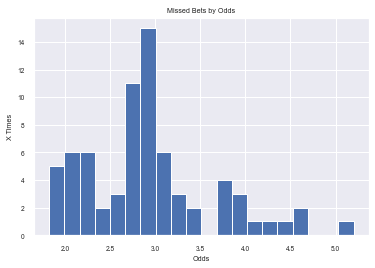

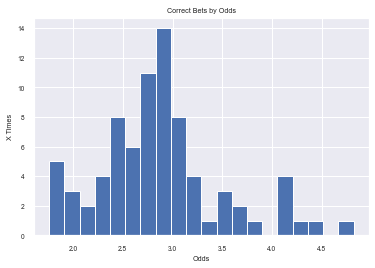

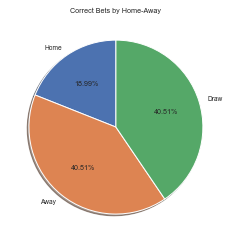

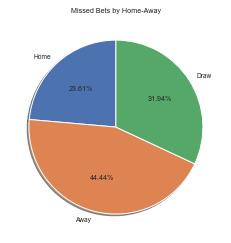

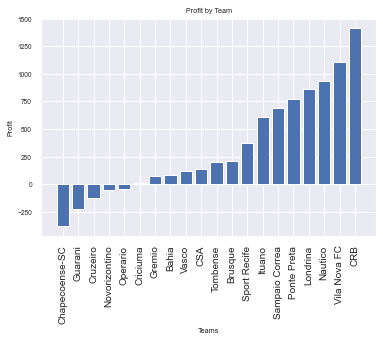

In [1504]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away', 'Draw'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away', 'Draw'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

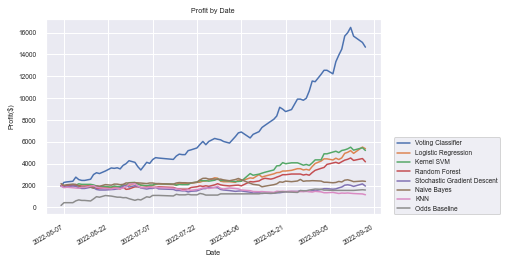

In [1505]:
xpoints = money_by_date[:,0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)
plt.plot(xpoints, bets_tracking_odds)

title = "Profit by Date"
plt.legend([x['model'] for x in results] + ['Odds Baseline'], loc=(1.04,0))
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()